In [4]:
DATA_PATH = "/kaggle/input/natural-language/paul_graham_essays.txt"  
OUT_DIR = "/kaggle/working/"                          # directory to save vocab & X/y
MIN_FREQ = 1                           # words with freq < MIN_FREQ -> <UNK>
CONTEXT_LEN = 8                        # context window size (C)

import re, json, os
from collections import Counter
import numpy as np

def clean_line_natural(line):
    # keep alphanumeric, space and period '.' only (as per instructions)
    line = re.sub(r"[^a-zA-Z0-9 \.]", "", line)
    line = line.lower()
    return line

# read file
with open(DATA_PATH, "r", encoding="utf-8", errors="ignore") as f:
    raw = f.read()

cleaned = clean_line_natural(raw)
# tokenization: simple whitespace tokenizer so '.' becomes a token if it's separated,
# ensure '.' is treated as a separate token by adding spaces around periods
cleaned = re.sub(r"\.", " . ", cleaned)
tokens = cleaned.split()
print(f"Total tokens (raw): {len(tokens)}")

Total tokens (raw): 554828


In [5]:
# frequency and vocab (apply MIN_FREQ to decide <UNK>)
freq = Counter(tokens)
# build vocab: keep PAD and UNK, then words with freq >= MIN_FREQ in descending freq order
vocab = ["<PAD>", "<UNK>"] + [w for w,c in freq.most_common() if c >= MIN_FREQ and w not in ("<pad>","<unk>")]
word2idx = {w:i for i,w in enumerate(vocab)}
idx2word = {i:w for w,i in word2idx.items()}

print(f"Vocabulary size (including <PAD>,<UNK>): {len(vocab)}")

# print 10 most frequent
print("\n10 most frequent tokens:")
for w,c in freq.most_common(10):
    print(f"{w:20} {c}")

# 10 least frequent tokens (tie-breaking by lexicographic order)
least = sorted(freq.items(), key=lambda x: (x[1], x[0]))[:10]
print("\n10 least frequent tokens:")
for w,c in least:
    print(f"{w:20} {c}")

Vocabulary size (including <PAD>,<UNK>): 46328

10 most frequent tokens:
.                    33769
the                  20849
to                   17752
a                    13263
of                   11879
you                  8510
and                  8091
that                 7775
in                   7723
is                   7360

10 least frequent tokens:
0001                 1
001                  1
001negative          1
01491078guarantee    1
01continuations      1
01describe           1
01example            1
01graham             1
01min                1
01morris             1


In [6]:
# create sliding-window (X,y) pairs across the whole text (period tokens are allowed)
# We will allow sliding across sentences/paragraphs here (as natural text). If you want to
# avoid crossing paragraphs, you'd split by double newline and do per-paragraph windows.
token_ids = [ word2idx.get(t, word2idx["<UNK>"]) for t in tokens ]

X_list, y_list = [], []
C = CONTEXT_LEN
for i in range(len(token_ids) - C):
    ctx = token_ids[i:i+C]
    tgt = token_ids[i+C]
    X_list.append(ctx)
    y_list.append(tgt)

X = np.array(X_list, dtype=np.int32)
y = np.array(y_list, dtype=np.int32)
print(f"\nCreated {len(X)} (X,y) pairs with context length {C}")

# save artifacts
os.makedirs(OUT_DIR, exist_ok=True)
with open(os.path.join(OUT_DIR, "vocab_paul_graham.json"), "w", encoding="utf-8") as f:
    json.dump(vocab, f, ensure_ascii=False, indent=2)
np.save(os.path.join(OUT_DIR, "X_paul_graham.npy"), X)
np.save(os.path.join(OUT_DIR, "y_paul_graham.npy"), y)

print(f"Saved vocab_paul_graham.json, X_paul_graham.npy, y_paul_graham.npy to {OUT_DIR}")


Created 554820 (X,y) pairs with context length 8
Saved vocab_paul_graham.json, X_paul_graham.npy, y_paul_graham.npy to /kaggle/working/


Loaded X shape: (554820, 8), y shape: (554820,)
Vocabulary size: 46328

SAMPLE (X → y) pairs:
 1. paul grahamnewgood writing founder modewant to start a  --->  startup
 2. grahamnewgood writing founder modewant to start a startup  --->  get
 3. writing founder modewant to start a startup get  --->  funded
 4. founder modewant to start a startup get funded  --->  by
 5. modewant to start a startup get funded by  --->  y


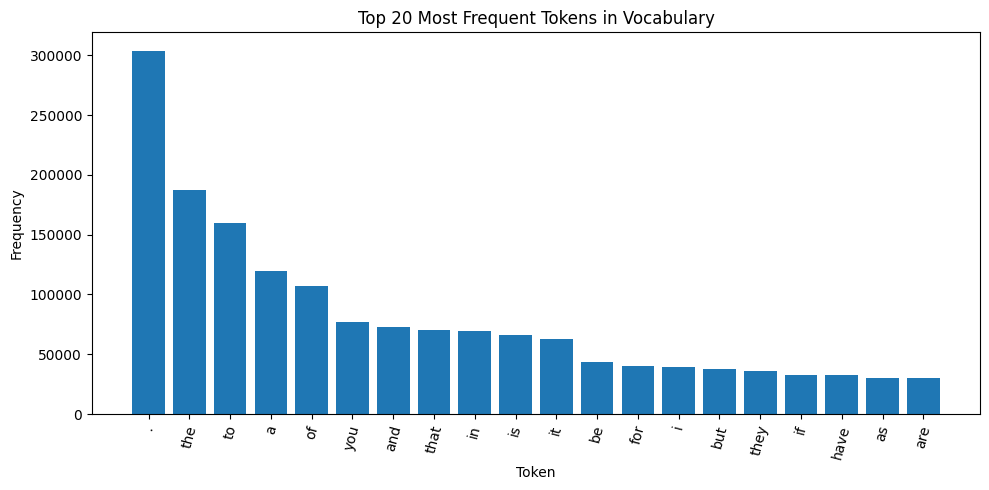

<UNK> appears 0 times in dataset.
<PAD> appears 0 times in dataset.


In [7]:
# === Visualize Vocabulary and (X, y) pairs ===
import json, numpy as np, matplotlib.pyplot as plt
from collections import Counter

VOCAB_PATH = "/kaggle/working/vocab_paul_graham.json"       # change as needed
X_PATH = "/kaggle/working/X_paul_graham.npy"
Y_PATH = "/kaggle/working/y_paul_graham.npy"

# === Load data ===
with open(VOCAB_PATH, 'r', encoding='utf-8') as f:
    vocab = json.load(f)
word2idx = {w:i for i,w in enumerate(vocab)}
idx2word = {i:w for w,i in word2idx.items()}

X = np.load(X_PATH)
y = np.load(Y_PATH)
print(f"Loaded X shape: {X.shape}, y shape: {y.shape}")
print(f"Vocabulary size: {len(vocab)}")

# === Display sample pairs in word form ===
n_show = 5
print("\nSAMPLE (X → y) pairs:")
for i in range(min(n_show, len(X))):
    ctx_words = [idx2word[idx] for idx in X[i]]
    target_word = idx2word[y[i]]
    print(f"{i+1:>2}. {' '.join(ctx_words)}  --->  {target_word}")

# Count frequencies from X and y combined
all_tokens = list(X.flatten()) + list(y)
freq = Counter(all_tokens)
sorted_freq = sorted(freq.items(), key=lambda x: x[1], reverse=True)

# pick top N to plot
N = 20
top_ids = [idx for idx,_ in sorted_freq[:N]]
top_words = [idx2word[i] for i in top_ids]
top_counts = [freq[i] for i in top_ids]

plt.figure(figsize=(10,5))
plt.bar(top_words, top_counts)
plt.xticks(rotation=75)
plt.title(f"Top {N} Most Frequent Tokens in Vocabulary")
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# === Sanity check for unknown or padding tokens ===
unk_idx = word2idx.get("<UNK>", None)
pad_idx = word2idx.get("<PAD>", None)
if unk_idx is not None:
    print(f"<UNK> appears {freq[unk_idx]} times in dataset.")
if pad_idx is not None:
    print(f"<PAD> appears {freq[pad_idx]} times in dataset.")


In [8]:
# -------------------------
import os, json, time, random
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

In [10]:

# CONFIG
EMBED_DIM = 64
HIDDEN_LAYERS = 2
HIDDEN_SIZE = 1024
ACTIVATION = "relu"
CONTEXT_LEN = None
BATCH_SIZE = 1024
LR = 1e-4
EPOCHS = 500
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
RESUME_FROM = None
SEED = 42

# reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

os.makedirs(OUT_DIR, exist_ok=True)

# load vocab & data (assumes VOCAB_PATH, X_PATH, Y_PATH are set)
with open(VOCAB_PATH, "r", encoding="utf-8") as f:
    vocab = json.load(f)
vocab_size = len(vocab)
word2idx = {w:i for i,w in enumerate(vocab)}
idx2word = {i:w for i,w in word2idx.items()}

X = np.load(X_PATH)
y = np.load(Y_PATH)
if CONTEXT_LEN is None: CONTEXT_LEN = X.shape[1]
print(f"Loaded X {X.shape}  y {y.shape}  vocab_size {vocab_size}  context={CONTEXT_LEN}")

# dataset / loaders
X_t, y_t = torch.from_numpy(X).long(), torch.from_numpy(y).long()
dataset = TensorDataset(X_t, y_t)
n_val = int(0.1 * len(dataset))
train_ds, val_ds = random_split(dataset, [len(dataset)-n_val, n_val], generator=torch.Generator().manual_seed(SEED))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
                          num_workers=4, pin_memory=True, persistent_workers=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=4, pin_memory=True, persistent_workers=True)

print("Train:", len(train_ds), " Val:", len(val_ds))

Loaded X (554820, 8)  y (554820,)  vocab_size 46328  context=8
Train: 499338  Val: 55482


In [13]:
# model
class MLPNextWord(nn.Module):
    def __init__(self, vocab_size, embed_dim, context_len, hidden_layers, hidden_size, activation):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        in_dim = embed_dim * context_len
        layers = []
        for _ in range(hidden_layers):
            layers.append(nn.Linear(in_dim, hidden_size))
            layers.append(nn.ReLU() if activation == "relu" else nn.Tanh())
            layers.append(nn.Dropout(0.2))
            in_dim = hidden_size
        layers.append(nn.Linear(in_dim, vocab_size))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        emb = self.embed(x)
        return self.net(emb.view(emb.size(0), -1))

model = MLPNextWord(vocab_size, EMBED_DIM, CONTEXT_LEN, HIDDEN_LAYERS, HIDDEN_SIZE, ACTIVATION).to(DEVICE)
print(f"Params: {sum(p.numel() for p in model.parameters()):,}")

Params: 52,026,104


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# resume if needed
start_epoch, best_val_loss = 1, float("inf")
if RESUME_FROM and os.path.isfile(RESUME_FROM):
    ck = torch.load(RESUME_FROM, map_location=DEVICE)
    model.load_state_dict(ck["model_state"])
    optimizer.load_state_dict(ck["opt_state"])
    best_val_loss = ck.get("best_val_loss", best_val_loss)
    start_epoch = ck["epoch"] + 1
    print("Resumed from", RESUME_FROM, "starting epoch", start_epoch)

# training full epochs
train_losses, val_losses, val_accs = [], [], []
for epoch in range(start_epoch, EPOCHS+1):
    t0 = time.time()
    # TRAIN
    model.train()
    total_loss = 0.0
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} train", leave=False):
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # VALIDATION
    model.eval()
    total_vloss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} val", leave=False):
            xb = xb.to(DEVICE, non_blocking=True)
            yb = yb.to(DEVICE, non_blocking=True)
            logits = model(xb)
            vloss = criterion(logits, yb)
            total_vloss += vloss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)
    val_loss = total_vloss / len(val_loader.dataset)
    val_acc  = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Save best model whenever validation loss improves (optional but safe)
    improved = val_loss < best_val_loss - 1e-6
    if improved:
        best_val_loss = val_loss
        ckpt = {
            "epoch": epoch,
            "model_state": model.state_dict(),
            "opt_state": optimizer.state_dict(),
            "val_loss": val_loss,
            "val_acc": val_acc,
            "best_val_loss": best_val_loss,
        }
        torch.save(ckpt, os.path.join(OUT_DIR, "best_model.pth"))

    print(f"Epoch {epoch:3d} | train {train_loss:.4f} | val {val_loss:.4f} | acc {val_acc:.4f} | "
          f"{'BEST' if improved else ''} | time {(time.time()-t0):.1f}s")

# END of epochs: ensure final/best model saved
best_model_path = os.path.join(OUT_DIR, "best_model.pth")
if not os.path.isfile(best_model_path):
    # no best saved during training — save final model
    print("No best model saved during training. Saving final model as fallback.")
    torch.save({
        "epoch": EPOCHS,
        "model_state": model.state_dict(),
        "opt_state": optimizer.state_dict(),
        "val_loss": val_losses[-1] if val_losses else None,
        "val_acc": val_accs[-1] if val_accs else None,
    }, best_model_path)
    print("Saved final model to:", best_model_path)
else:
    print("Best model already exists at:", best_model_path)

# reload best model for inspection
model.load_state_dict(torch.load(best_model_path, map_location=DEVICE)["model_state"])
print("Loaded best model.")

# plot losses
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss curves"); plt.grid(True); plt.show()

# save metrics
json.dump({"train_losses":train_losses,"val_losses":val_losses,"val_accs":val_accs},
          open(os.path.join(OUT_DIR,"training_metrics.json"),"w"), indent=2)
print("Training finished. Best val loss:", best_val_loss)
print("Metrics and final/best model saved in:", OUT_DIR)

Loaded X (554820, 8)  y (554820,)  vocab_size 46328  context=8
Train: 499338  Val: 55482
Params: 52,026,104


Epoch 1/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 1/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch   1 | train 7.2141 | val 6.8844 | acc 0.0864 | BEST | time 28.5s


Epoch 2/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 2/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch   2 | train 6.6671 | val 6.7583 | acc 0.0979 | BEST | time 27.2s


Epoch 3/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 3/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch   3 | train 6.4293 | val 6.6762 | acc 0.1056 | BEST | time 27.1s


Epoch 4/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 4/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch   4 | train 6.2451 | val 6.6246 | acc 0.1123 | BEST | time 29.3s


Epoch 5/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 5/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch   5 | train 6.0834 | val 6.5910 | acc 0.1167 | BEST | time 27.3s


Epoch 6/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 6/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch   6 | train 5.9337 | val 6.5708 | acc 0.1204 | BEST | time 27.2s


Epoch 7/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 7/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch   7 | train 5.7824 | val 6.5594 | acc 0.1249 | BEST | time 27.2s


Epoch 8/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 8/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch   8 | train 5.6224 | val 6.5709 | acc 0.1280 |  | time 26.1s


Epoch 9/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 9/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch   9 | train 5.4399 | val 6.6033 | acc 0.1303 |  | time 25.4s


Epoch 10/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 10/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  10 | train 5.2190 | val 6.6917 | acc 0.1325 |  | time 25.4s


Epoch 11/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 11/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  11 | train 4.9423 | val 6.8439 | acc 0.1348 |  | time 26.1s


Epoch 12/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 12/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  12 | train 4.6419 | val 6.9914 | acc 0.1370 |  | time 25.4s


Epoch 13/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 13/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  13 | train 4.4196 | val 7.0924 | acc 0.1393 |  | time 25.4s


Epoch 14/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 14/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  14 | train 4.2757 | val 7.1598 | acc 0.1404 |  | time 26.0s


Epoch 15/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 15/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  15 | train 4.1673 | val 7.2173 | acc 0.1410 |  | time 25.4s


Epoch 16/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 16/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  16 | train 4.0783 | val 7.2679 | acc 0.1417 |  | time 25.4s


Epoch 17/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 17/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  17 | train 4.0030 | val 7.3003 | acc 0.1435 |  | time 25.4s


Epoch 18/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 18/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  18 | train 3.9332 | val 7.3445 | acc 0.1442 |  | time 26.4s


Epoch 19/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 19/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  19 | train 3.8669 | val 7.3826 | acc 0.1455 |  | time 25.4s


Epoch 20/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 20/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  20 | train 3.8082 | val 7.4103 | acc 0.1448 |  | time 25.4s


Epoch 21/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 21/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  21 | train 3.7508 | val 7.4497 | acc 0.1460 |  | time 26.0s


Epoch 22/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 22/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  22 | train 3.6973 | val 7.4799 | acc 0.1477 |  | time 25.4s


Epoch 23/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 23/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  23 | train 3.6467 | val 7.5259 | acc 0.1487 |  | time 25.4s


Epoch 24/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 24/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  24 | train 3.5992 | val 7.5371 | acc 0.1484 |  | time 26.0s


Epoch 25/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 25/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  25 | train 3.5517 | val 7.5667 | acc 0.1486 |  | time 25.4s


Epoch 26/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 26/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  26 | train 3.5080 | val 7.5843 | acc 0.1496 |  | time 25.4s


Epoch 27/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 27/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  27 | train 3.4669 | val 7.6040 | acc 0.1486 |  | time 25.8s


Epoch 28/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 28/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  28 | train 3.4236 | val 7.6301 | acc 0.1498 |  | time 25.6s


Epoch 29/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 29/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  29 | train 3.3842 | val 7.6516 | acc 0.1493 |  | time 25.4s


Epoch 30/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 30/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  30 | train 3.3493 | val 7.6769 | acc 0.1495 |  | time 25.9s


Epoch 31/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 31/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  31 | train 3.3086 | val 7.7043 | acc 0.1519 |  | time 26.5s


Epoch 32/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 32/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  32 | train 3.2736 | val 7.7343 | acc 0.1512 |  | time 25.9s


Epoch 33/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 33/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  33 | train 3.2383 | val 7.7506 | acc 0.1517 |  | time 25.4s


Epoch 34/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 34/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  34 | train 3.2059 | val 7.7635 | acc 0.1518 |  | time 26.0s


Epoch 35/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 35/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  35 | train 3.1732 | val 7.8170 | acc 0.1534 |  | time 25.4s


Epoch 36/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 36/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  36 | train 3.1438 | val 7.8143 | acc 0.1520 |  | time 25.4s


Epoch 37/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 37/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  37 | train 3.1103 | val 7.8479 | acc 0.1530 |  | time 25.8s


Epoch 38/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 38/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  38 | train 3.0834 | val 7.8654 | acc 0.1519 |  | time 25.6s


Epoch 39/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 39/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  39 | train 3.0534 | val 7.8822 | acc 0.1547 |  | time 25.4s


Epoch 40/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 40/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  40 | train 3.0265 | val 7.9258 | acc 0.1539 |  | time 25.4s


Epoch 41/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 41/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  41 | train 2.9994 | val 7.9220 | acc 0.1539 |  | time 26.0s


Epoch 42/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 42/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  42 | train 2.9716 | val 7.9462 | acc 0.1542 |  | time 25.4s


Epoch 43/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 43/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  43 | train 2.9452 | val 8.0035 | acc 0.1549 |  | time 25.4s


Epoch 44/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 44/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  44 | train 2.9227 | val 8.0170 | acc 0.1546 |  | time 26.1s


Epoch 45/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 45/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  45 | train 2.8984 | val 8.0172 | acc 0.1553 |  | time 25.4s


Epoch 46/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 46/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  46 | train 2.8749 | val 8.0283 | acc 0.1539 |  | time 25.4s


Epoch 47/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 47/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  47 | train 2.8530 | val 8.0605 | acc 0.1557 |  | time 25.8s


Epoch 48/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 48/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  48 | train 2.8276 | val 8.0659 | acc 0.1552 |  | time 25.6s


Epoch 49/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 49/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  49 | train 2.8085 | val 8.0917 | acc 0.1544 |  | time 25.4s


Epoch 50/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 50/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  50 | train 2.7858 | val 8.1157 | acc 0.1553 |  | time 25.4s


Epoch 51/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 51/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  51 | train 2.7641 | val 8.1397 | acc 0.1555 |  | time 26.0s


Epoch 52/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 52/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  52 | train 2.7444 | val 8.1590 | acc 0.1564 |  | time 25.4s


Epoch 53/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 53/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  53 | train 2.7226 | val 8.1668 | acc 0.1561 |  | time 25.4s


Epoch 54/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 54/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  54 | train 2.7040 | val 8.1945 | acc 0.1565 |  | time 26.0s


Epoch 55/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 55/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  55 | train 2.6846 | val 8.2015 | acc 0.1566 |  | time 25.8s


Epoch 56/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 56/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  56 | train 2.6649 | val 8.2372 | acc 0.1571 |  | time 25.4s


Epoch 57/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 57/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  57 | train 2.6495 | val 8.2281 | acc 0.1557 |  | time 25.8s


Epoch 58/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 58/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  58 | train 2.6280 | val 8.2411 | acc 0.1553 |  | time 25.6s


Epoch 59/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 59/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  59 | train 2.6117 | val 8.3004 | acc 0.1565 |  | time 25.8s


Epoch 60/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 60/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  60 | train 2.5950 | val 8.2887 | acc 0.1577 |  | time 25.9s


Epoch 61/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 61/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  61 | train 2.5783 | val 8.3062 | acc 0.1580 |  | time 26.0s


Epoch 62/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 62/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  62 | train 2.5616 | val 8.3194 | acc 0.1580 |  | time 25.4s


Epoch 63/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 63/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  63 | train 2.5446 | val 8.3565 | acc 0.1583 |  | time 25.4s


Epoch 64/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 64/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  64 | train 2.5289 | val 8.3763 | acc 0.1573 |  | time 26.0s


Epoch 65/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 65/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  65 | train 2.5170 | val 8.3548 | acc 0.1573 |  | time 25.4s


Epoch 66/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 66/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  66 | train 2.4991 | val 8.3827 | acc 0.1581 |  | time 25.4s


Epoch 67/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 67/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  67 | train 2.4856 | val 8.3790 | acc 0.1573 |  | time 25.8s


Epoch 68/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 68/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  68 | train 2.4682 | val 8.4246 | acc 0.1584 |  | time 25.7s


Epoch 69/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 69/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  69 | train 2.4548 | val 8.4295 | acc 0.1580 |  | time 25.6s


Epoch 70/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 70/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  70 | train 2.4409 | val 8.4324 | acc 0.1585 |  | time 26.0s


Epoch 71/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 71/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  71 | train 2.4275 | val 8.4574 | acc 0.1582 |  | time 25.8s


Epoch 72/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 72/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  72 | train 2.4126 | val 8.4678 | acc 0.1582 |  | time 25.6s


Epoch 73/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 73/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  73 | train 2.3993 | val 8.4771 | acc 0.1583 |  | time 25.6s


Epoch 74/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 74/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  74 | train 2.3870 | val 8.5185 | acc 0.1593 |  | time 26.3s


Epoch 75/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 75/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  75 | train 2.3746 | val 8.5226 | acc 0.1583 |  | time 25.6s


Epoch 76/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 76/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  76 | train 2.3592 | val 8.5100 | acc 0.1582 |  | time 25.7s


Epoch 77/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 77/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  77 | train 2.3506 | val 8.5386 | acc 0.1582 |  | time 26.1s


Epoch 78/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 78/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  78 | train 2.3348 | val 8.5514 | acc 0.1593 |  | time 25.9s


Epoch 79/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 79/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  79 | train 2.3240 | val 8.5696 | acc 0.1592 |  | time 25.6s


Epoch 80/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 80/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  80 | train 2.3119 | val 8.5860 | acc 0.1612 |  | time 26.1s


Epoch 81/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 81/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  81 | train 2.2996 | val 8.5835 | acc 0.1596 |  | time 26.3s


Epoch 82/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 82/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  82 | train 2.2892 | val 8.6007 | acc 0.1590 |  | time 25.4s


Epoch 83/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 83/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  83 | train 2.2756 | val 8.6427 | acc 0.1594 |  | time 25.4s


Epoch 84/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 84/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  84 | train 2.2672 | val 8.6270 | acc 0.1592 |  | time 26.0s


Epoch 85/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 85/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  85 | train 2.2549 | val 8.6530 | acc 0.1601 |  | time 25.3s


Epoch 86/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 86/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  86 | train 2.2426 | val 8.6674 | acc 0.1597 |  | time 26.3s


Epoch 87/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 87/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  87 | train 2.2318 | val 8.6712 | acc 0.1606 |  | time 25.8s


Epoch 88/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 88/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  88 | train 2.2213 | val 8.6734 | acc 0.1594 |  | time 25.6s


Epoch 89/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 89/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  89 | train 2.2082 | val 8.7122 | acc 0.1590 |  | time 25.4s


Epoch 90/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 90/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  90 | train 2.1991 | val 8.7068 | acc 0.1601 |  | time 25.8s


Epoch 91/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 91/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  91 | train 2.1929 | val 8.7088 | acc 0.1599 |  | time 25.5s


Epoch 92/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 92/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  92 | train 2.1823 | val 8.7182 | acc 0.1608 |  | time 25.4s


Epoch 93/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 93/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  93 | train 2.1710 | val 8.7430 | acc 0.1586 |  | time 25.4s


Epoch 94/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 94/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  94 | train 2.1603 | val 8.7470 | acc 0.1592 |  | time 26.0s


Epoch 95/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 95/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  95 | train 2.1499 | val 8.7424 | acc 0.1614 |  | time 25.4s


Epoch 96/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 96/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  96 | train 2.1419 | val 8.7537 | acc 0.1596 |  | time 25.4s


Epoch 97/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 97/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  97 | train 2.1307 | val 8.7682 | acc 0.1593 |  | time 25.8s


Epoch 98/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 98/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  98 | train 2.1238 | val 8.7710 | acc 0.1606 |  | time 25.6s


Epoch 99/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 99/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  99 | train 2.1138 | val 8.8203 | acc 0.1591 |  | time 25.4s


Epoch 100/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 100/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 100 | train 2.1030 | val 8.8185 | acc 0.1593 |  | time 25.8s


Epoch 101/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 101/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 101 | train 2.0924 | val 8.8165 | acc 0.1592 |  | time 25.6s


Epoch 102/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 102/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 102 | train 2.0852 | val 8.8279 | acc 0.1605 |  | time 25.3s


Epoch 103/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 103/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 103 | train 2.0734 | val 8.8438 | acc 0.1610 |  | time 25.3s


Epoch 104/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 104/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 104 | train 2.0657 | val 8.8718 | acc 0.1592 |  | time 26.0s


Epoch 105/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 105/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 105 | train 2.0574 | val 8.8484 | acc 0.1614 |  | time 25.4s


Epoch 106/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 106/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 106 | train 2.0494 | val 8.8884 | acc 0.1611 |  | time 25.3s


Epoch 107/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 107/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 107 | train 2.0412 | val 8.8676 | acc 0.1605 |  | time 26.3s


Epoch 108/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 108/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 108 | train 2.0341 | val 8.8857 | acc 0.1610 |  | time 25.6s


Epoch 109/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 109/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 109 | train 2.0244 | val 8.8810 | acc 0.1596 |  | time 25.4s


Epoch 110/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 110/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 110 | train 2.0201 | val 8.8875 | acc 0.1604 |  | time 25.8s


Epoch 111/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 111/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 111 | train 2.0083 | val 8.9276 | acc 0.1604 |  | time 25.6s


Epoch 112/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 112/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 112 | train 2.0011 | val 8.9203 | acc 0.1610 |  | time 25.4s


Epoch 113/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 113/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 113 | train 1.9924 | val 8.9243 | acc 0.1613 |  | time 25.9s


Epoch 114/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 114/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 114 | train 1.9848 | val 8.9387 | acc 0.1606 |  | time 26.7s


Epoch 115/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 115/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 115 | train 1.9761 | val 8.9335 | acc 0.1599 |  | time 25.4s


Epoch 116/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 116/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 116 | train 1.9712 | val 8.9678 | acc 0.1618 |  | time 25.3s


Epoch 117/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 117/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 117 | train 1.9623 | val 8.9739 | acc 0.1610 |  | time 25.7s


Epoch 118/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 118/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 118 | train 1.9553 | val 8.9680 | acc 0.1602 |  | time 25.5s


Epoch 119/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 119/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 119 | train 1.9473 | val 8.9673 | acc 0.1614 |  | time 25.5s


Epoch 120/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 120/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 120 | train 1.9394 | val 8.9859 | acc 0.1613 |  | time 25.8s


Epoch 121/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 121/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 121 | train 1.9344 | val 8.9930 | acc 0.1610 |  | time 25.6s


Epoch 122/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 122/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 122 | train 1.9253 | val 9.0196 | acc 0.1617 |  | time 25.3s


Epoch 123/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 123/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 123 | train 1.9191 | val 8.9935 | acc 0.1608 |  | time 25.8s


Epoch 124/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 124/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 124 | train 1.9114 | val 9.0034 | acc 0.1606 |  | time 25.6s


Epoch 125/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 125/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 125 | train 1.9039 | val 9.0144 | acc 0.1599 |  | time 25.4s


Epoch 126/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 126/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 126 | train 1.8962 | val 9.0247 | acc 0.1594 |  | time 25.4s


Epoch 127/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 127/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 127 | train 1.8920 | val 9.0375 | acc 0.1604 |  | time 25.8s


Epoch 128/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 128/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 128 | train 1.8841 | val 9.0697 | acc 0.1605 |  | time 25.5s


Epoch 129/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 129/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 129 | train 1.8768 | val 9.0502 | acc 0.1613 |  | time 26.0s


Epoch 130/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 130/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 130 | train 1.8720 | val 9.0575 | acc 0.1603 |  | time 26.0s


Epoch 131/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 131/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 131 | train 1.8615 | val 9.0636 | acc 0.1615 |  | time 25.6s


Epoch 132/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 132/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 132 | train 1.8574 | val 9.0966 | acc 0.1601 |  | time 25.9s


Epoch 133/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 133/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 133 | train 1.8512 | val 9.0784 | acc 0.1603 |  | time 26.0s


Epoch 134/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 134/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 134 | train 1.8434 | val 9.0824 | acc 0.1613 |  | time 25.5s


Epoch 135/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 135/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 135 | train 1.8387 | val 9.0822 | acc 0.1620 |  | time 26.1s


Epoch 136/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 136/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 136 | train 1.8301 | val 9.1127 | acc 0.1596 |  | time 25.5s


Epoch 137/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 137/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 137 | train 1.8225 | val 9.0878 | acc 0.1599 |  | time 26.0s


Epoch 138/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 138/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 138 | train 1.8215 | val 9.1230 | acc 0.1603 |  | time 25.7s


Epoch 139/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 139/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 139 | train 1.8135 | val 9.1304 | acc 0.1602 |  | time 25.5s


Epoch 140/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 140/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 140 | train 1.8039 | val 9.1471 | acc 0.1611 |  | time 26.5s


Epoch 141/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 141/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 141 | train 1.8012 | val 9.1425 | acc 0.1604 |  | time 26.2s


Epoch 142/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 142/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 142 | train 1.7959 | val 9.1480 | acc 0.1603 |  | time 25.6s


Epoch 143/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 143/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 143 | train 1.7884 | val 9.1653 | acc 0.1606 |  | time 26.1s


Epoch 144/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 144/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 144 | train 1.7823 | val 9.1511 | acc 0.1603 |  | time 25.7s


Epoch 145/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 145/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 145 | train 1.7744 | val 9.1851 | acc 0.1596 |  | time 26.2s


Epoch 146/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 146/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 146 | train 1.7720 | val 9.1467 | acc 0.1603 |  | time 25.6s


Epoch 147/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 147/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 147 | train 1.7667 | val 9.1801 | acc 0.1601 |  | time 26.2s


Epoch 148/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 148/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 148 | train 1.7597 | val 9.1973 | acc 0.1617 |  | time 25.8s


Epoch 149/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 149/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 149 | train 1.7532 | val 9.1814 | acc 0.1606 |  | time 25.6s


Epoch 150/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 150/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 150 | train 1.7471 | val 9.1967 | acc 0.1604 |  | time 26.1s


Epoch 151/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 151/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 151 | train 1.7430 | val 9.2102 | acc 0.1607 |  | time 25.8s


Epoch 152/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 152/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 152 | train 1.7342 | val 9.2104 | acc 0.1595 |  | time 25.6s


Epoch 153/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 153/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 153 | train 1.7315 | val 9.2097 | acc 0.1602 |  | time 26.2s


Epoch 154/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 154/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 154 | train 1.7250 | val 9.2157 | acc 0.1608 |  | time 25.6s


Epoch 155/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 155/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 155 | train 1.7191 | val 9.2346 | acc 0.1601 |  | time 25.8s


Epoch 156/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 156/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 156 | train 1.7158 | val 9.2538 | acc 0.1617 |  | time 25.6s


Epoch 157/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 157/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 157 | train 1.7093 | val 9.2551 | acc 0.1607 |  | time 26.0s


Epoch 158/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 158/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 158 | train 1.7022 | val 9.2619 | acc 0.1604 |  | time 26.2s


Epoch 159/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 159/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 159 | train 1.7002 | val 9.2714 | acc 0.1616 |  | time 25.5s


Epoch 160/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 160/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 160 | train 1.6949 | val 9.2638 | acc 0.1608 |  | time 26.0s


Epoch 161/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 161/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 161 | train 1.6873 | val 9.2703 | acc 0.1612 |  | time 25.7s


Epoch 162/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 162/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 162 | train 1.6822 | val 9.2718 | acc 0.1597 |  | time 25.5s


Epoch 163/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 163/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 163 | train 1.6762 | val 9.3065 | acc 0.1603 |  | time 26.0s


Epoch 164/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 164/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 164 | train 1.6739 | val 9.2848 | acc 0.1610 |  | time 25.5s


Epoch 165/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 165/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 165 | train 1.6672 | val 9.3262 | acc 0.1627 |  | time 25.7s


Epoch 166/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 166/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 166 | train 1.6625 | val 9.3200 | acc 0.1606 |  | time 25.6s


Epoch 167/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 167/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 167 | train 1.6595 | val 9.3233 | acc 0.1608 |  | time 26.3s


Epoch 168/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 168/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 168 | train 1.6540 | val 9.3374 | acc 0.1620 |  | time 26.2s


Epoch 169/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 169/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 169 | train 1.6490 | val 9.3307 | acc 0.1611 |  | time 26.1s


Epoch 170/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 170/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 170 | train 1.6457 | val 9.3095 | acc 0.1607 |  | time 26.0s


Epoch 171/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 171/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 171 | train 1.6363 | val 9.3238 | acc 0.1610 |  | time 25.7s


Epoch 172/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 172/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 172 | train 1.6348 | val 9.3388 | acc 0.1612 |  | time 25.5s


Epoch 173/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 173/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 173 | train 1.6300 | val 9.3538 | acc 0.1605 |  | time 26.0s


Epoch 174/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 174/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 174 | train 1.6241 | val 9.3659 | acc 0.1604 |  | time 25.5s


Epoch 175/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 175/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 175 | train 1.6197 | val 9.3684 | acc 0.1613 |  | time 25.7s


Epoch 176/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 176/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 176 | train 1.6170 | val 9.3787 | acc 0.1626 |  | time 26.0s


Epoch 177/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 177/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 177 | train 1.6057 | val 9.3742 | acc 0.1608 |  | time 25.5s


Epoch 178/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 178/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 178 | train 1.6062 | val 9.3686 | acc 0.1610 |  | time 25.7s


Epoch 179/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 179/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 179 | train 1.6014 | val 9.3942 | acc 0.1624 |  | time 25.5s


Epoch 180/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 180/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 180 | train 1.5966 | val 9.3826 | acc 0.1610 |  | time 26.1s


Epoch 181/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 181/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 181 | train 1.5919 | val 9.3849 | acc 0.1601 |  | time 25.8s


Epoch 182/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 182/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 182 | train 1.5859 | val 9.3998 | acc 0.1612 |  | time 25.5s


Epoch 183/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 183/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 183 | train 1.5823 | val 9.4073 | acc 0.1609 |  | time 26.1s


Epoch 184/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 184/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 184 | train 1.5755 | val 9.4240 | acc 0.1616 |  | time 26.1s


Epoch 185/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 185/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 185 | train 1.5750 | val 9.4017 | acc 0.1613 |  | time 25.7s


Epoch 186/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 186/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 186 | train 1.5681 | val 9.4095 | acc 0.1604 |  | time 26.0s


Epoch 187/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 187/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 187 | train 1.5664 | val 9.4231 | acc 0.1602 |  | time 25.5s


Epoch 188/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 188/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 188 | train 1.5610 | val 9.4408 | acc 0.1604 |  | time 25.8s


Epoch 189/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 189/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 189 | train 1.5567 | val 9.4553 | acc 0.1601 |  | time 25.5s


Epoch 190/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 190/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 190 | train 1.5498 | val 9.4511 | acc 0.1622 |  | time 26.0s


Epoch 191/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 191/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 191 | train 1.5513 | val 9.4469 | acc 0.1620 |  | time 25.8s


Epoch 192/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 192/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 192 | train 1.5408 | val 9.4593 | acc 0.1602 |  | time 25.5s


Epoch 193/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 193/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 193 | train 1.5416 | val 9.4583 | acc 0.1601 |  | time 26.1s


Epoch 194/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 194/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 194 | train 1.5324 | val 9.4691 | acc 0.1601 |  | time 25.5s


Epoch 195/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 195/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 195 | train 1.5322 | val 9.4741 | acc 0.1618 |  | time 26.4s


Epoch 196/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 196/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 196 | train 1.5279 | val 9.4761 | acc 0.1600 |  | time 26.5s


Epoch 197/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 197/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 197 | train 1.5227 | val 9.4840 | acc 0.1613 |  | time 25.5s


Epoch 198/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 198/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 198 | train 1.5169 | val 9.5065 | acc 0.1611 |  | time 25.7s


Epoch 199/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 199/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 199 | train 1.5136 | val 9.4875 | acc 0.1622 |  | time 25.5s


Epoch 200/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 200/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 200 | train 1.5099 | val 9.4949 | acc 0.1607 |  | time 26.0s


Epoch 201/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 201/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 201 | train 1.5042 | val 9.5124 | acc 0.1605 |  | time 25.8s


Epoch 202/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 202/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 202 | train 1.5049 | val 9.5011 | acc 0.1601 |  | time 25.5s


Epoch 203/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 203/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 203 | train 1.4996 | val 9.5215 | acc 0.1600 |  | time 25.9s


Epoch 204/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 204/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 204 | train 1.4915 | val 9.5418 | acc 0.1611 |  | time 25.5s


Epoch 205/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 205/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 205 | train 1.4919 | val 9.5341 | acc 0.1609 |  | time 25.7s


Epoch 206/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 206/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 206 | train 1.4887 | val 9.5150 | acc 0.1616 |  | time 25.9s


Epoch 207/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 207/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 207 | train 1.4833 | val 9.5602 | acc 0.1610 |  | time 25.5s


Epoch 208/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 208/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 208 | train 1.4782 | val 9.5424 | acc 0.1620 |  | time 25.8s


Epoch 209/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 209/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 209 | train 1.4748 | val 9.5764 | acc 0.1609 |  | time 26.0s


Epoch 210/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 210/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 210 | train 1.4701 | val 9.5686 | acc 0.1608 |  | time 26.0s


Epoch 211/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 211/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 211 | train 1.4650 | val 9.5727 | acc 0.1617 |  | time 25.7s


Epoch 212/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 212/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 212 | train 1.4657 | val 9.5685 | acc 0.1613 |  | time 25.5s


Epoch 213/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 213/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 213 | train 1.4615 | val 9.5596 | acc 0.1611 |  | time 26.0s


Epoch 214/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 214/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 214 | train 1.4548 | val 9.6009 | acc 0.1619 |  | time 25.5s


Epoch 215/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 215/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 215 | train 1.4508 | val 9.5975 | acc 0.1601 |  | time 25.7s


Epoch 216/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 216/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 216 | train 1.4477 | val 9.6086 | acc 0.1615 |  | time 26.0s


Epoch 217/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 217/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 217 | train 1.4426 | val 9.5963 | acc 0.1611 |  | time 25.5s


Epoch 218/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 218/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 218 | train 1.4406 | val 9.5925 | acc 0.1607 |  | time 25.8s


Epoch 219/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 219/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 219 | train 1.4356 | val 9.6155 | acc 0.1600 |  | time 25.5s


Epoch 220/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 220/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 220 | train 1.4341 | val 9.6112 | acc 0.1613 |  | time 26.4s


Epoch 221/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 221/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 221 | train 1.4306 | val 9.6240 | acc 0.1602 |  | time 26.3s


Epoch 222/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 222/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 222 | train 1.4287 | val 9.6311 | acc 0.1608 |  | time 25.5s


Epoch 223/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 223/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 223 | train 1.4222 | val 9.6481 | acc 0.1608 |  | time 26.4s


Epoch 224/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 224/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 224 | train 1.4181 | val 9.6452 | acc 0.1598 |  | time 25.5s


Epoch 225/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 225/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 225 | train 1.4160 | val 9.6407 | acc 0.1608 |  | time 25.7s


Epoch 226/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 226/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 226 | train 1.4117 | val 9.6791 | acc 0.1602 |  | time 26.0s


Epoch 227/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 227/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 227 | train 1.4111 | val 9.6269 | acc 0.1592 |  | time 25.5s


Epoch 228/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 228/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 228 | train 1.4049 | val 9.6629 | acc 0.1599 |  | time 25.7s


Epoch 229/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 229/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 229 | train 1.4005 | val 9.6594 | acc 0.1603 |  | time 25.9s


Epoch 230/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 230/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 230 | train 1.3980 | val 9.6782 | acc 0.1596 |  | time 25.5s


Epoch 231/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 231/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 231 | train 1.3946 | val 9.6743 | acc 0.1599 |  | time 25.7s


Epoch 232/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 232/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 232 | train 1.3883 | val 9.6683 | acc 0.1598 |  | time 25.6s


Epoch 233/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 233/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 233 | train 1.3857 | val 9.6697 | acc 0.1606 |  | time 26.0s


Epoch 234/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 234/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 234 | train 1.3823 | val 9.7124 | acc 0.1598 |  | time 25.6s


Epoch 235/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 235/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 235 | train 1.3836 | val 9.6978 | acc 0.1594 |  | time 26.2s


Epoch 236/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 236/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 236 | train 1.3765 | val 9.7043 | acc 0.1600 |  | time 26.0s


Epoch 237/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 237/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 237 | train 1.3762 | val 9.6737 | acc 0.1602 |  | time 25.5s


Epoch 238/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 238/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 238 | train 1.3722 | val 9.6873 | acc 0.1589 |  | time 25.7s


Epoch 239/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 239/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 239 | train 1.3680 | val 9.7102 | acc 0.1592 |  | time 26.0s


Epoch 240/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 240/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 240 | train 1.3623 | val 9.7127 | acc 0.1599 |  | time 25.5s


Epoch 241/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 241/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 241 | train 1.3612 | val 9.7061 | acc 0.1604 |  | time 25.7s


Epoch 242/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 242/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 242 | train 1.3585 | val 9.7028 | acc 0.1607 |  | time 25.5s


Epoch 243/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 243/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 243 | train 1.3550 | val 9.6960 | acc 0.1601 |  | time 26.0s


Epoch 244/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 244/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 244 | train 1.3521 | val 9.7447 | acc 0.1601 |  | time 25.5s


Epoch 245/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 245/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 245 | train 1.3487 | val 9.7411 | acc 0.1603 |  | time 25.7s


Epoch 246/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 246/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 246 | train 1.3449 | val 9.7234 | acc 0.1591 |  | time 26.0s


Epoch 247/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 247/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 247 | train 1.3440 | val 9.7540 | acc 0.1603 |  | time 25.5s


Epoch 248/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 248/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 248 | train 1.3381 | val 9.7552 | acc 0.1585 |  | time 25.7s


Epoch 249/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 249/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 249 | train 1.3354 | val 9.7640 | acc 0.1596 |  | time 26.6s


Epoch 250/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 250/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 250 | train 1.3354 | val 9.7637 | acc 0.1592 |  | time 25.5s


Epoch 251/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 251/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 251 | train 1.3286 | val 9.7591 | acc 0.1590 |  | time 26.3s


Epoch 252/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 252/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 252 | train 1.3283 | val 9.7782 | acc 0.1589 |  | time 25.5s


Epoch 253/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 253/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 253 | train 1.3196 | val 9.7993 | acc 0.1600 |  | time 26.0s


Epoch 254/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 254/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 254 | train 1.3199 | val 9.7599 | acc 0.1592 |  | time 25.5s


Epoch 255/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 255/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 255 | train 1.3176 | val 9.7765 | acc 0.1603 |  | time 25.7s


Epoch 256/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 256/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 256 | train 1.3139 | val 9.7918 | acc 0.1595 |  | time 26.0s


Epoch 257/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 257/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 257 | train 1.3126 | val 9.7861 | acc 0.1602 |  | time 25.5s


Epoch 258/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 258/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 258 | train 1.3044 | val 9.8231 | acc 0.1605 |  | time 25.7s


Epoch 259/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 259/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 259 | train 1.3083 | val 9.7973 | acc 0.1601 |  | time 26.0s


Epoch 260/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 260/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 260 | train 1.3042 | val 9.8106 | acc 0.1600 |  | time 25.5s


Epoch 261/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 261/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 261 | train 1.2980 | val 9.8144 | acc 0.1592 |  | time 26.3s


Epoch 262/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 262/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 262 | train 1.2956 | val 9.7990 | acc 0.1586 |  | time 25.6s


Epoch 263/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 263/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 263 | train 1.2936 | val 9.8123 | acc 0.1595 |  | time 26.1s


Epoch 264/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 264/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 264 | train 1.2881 | val 9.8520 | acc 0.1593 |  | time 25.5s


Epoch 265/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 265/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 265 | train 1.2840 | val 9.8247 | acc 0.1594 |  | time 25.8s


Epoch 266/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 266/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 266 | train 1.2828 | val 9.8509 | acc 0.1607 |  | time 26.0s


Epoch 267/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 267/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 267 | train 1.2824 | val 9.8665 | acc 0.1594 |  | time 25.5s


Epoch 268/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 268/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 268 | train 1.2771 | val 9.8577 | acc 0.1591 |  | time 25.7s


Epoch 269/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 269/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 269 | train 1.2749 | val 9.8538 | acc 0.1597 |  | time 26.0s


Epoch 270/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 270/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 270 | train 1.2725 | val 9.8614 | acc 0.1600 |  | time 25.5s


Epoch 271/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 271/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 271 | train 1.2682 | val 9.8688 | acc 0.1597 |  | time 25.7s


Epoch 272/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 272/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 272 | train 1.2693 | val 9.8554 | acc 0.1594 |  | time 25.6s


Epoch 273/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 273/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 273 | train 1.2627 | val 9.8688 | acc 0.1599 |  | time 26.7s


Epoch 274/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 274/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 274 | train 1.2647 | val 9.8721 | acc 0.1601 |  | time 25.5s


Epoch 275/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 275/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 275 | train 1.2587 | val 9.8796 | acc 0.1602 |  | time 25.7s


Epoch 276/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 276/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 276 | train 1.2568 | val 9.8766 | acc 0.1590 |  | time 26.0s


Epoch 277/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 277/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 277 | train 1.2505 | val 9.8785 | acc 0.1591 |  | time 25.9s


Epoch 278/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 278/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 278 | train 1.2530 | val 9.8823 | acc 0.1596 |  | time 26.2s


Epoch 279/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 279/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 279 | train 1.2447 | val 9.9037 | acc 0.1603 |  | time 25.9s


Epoch 280/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 280/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 280 | train 1.2442 | val 9.9229 | acc 0.1590 |  | time 25.5s


Epoch 281/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 281/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 281 | train 1.2431 | val 9.9051 | acc 0.1595 |  | time 25.7s


Epoch 282/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 282/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 282 | train 1.2369 | val 9.9217 | acc 0.1603 |  | time 26.1s


Epoch 283/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 283/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 283 | train 1.2386 | val 9.9197 | acc 0.1600 |  | time 25.5s


Epoch 284/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 284/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 284 | train 1.2340 | val 9.9143 | acc 0.1604 |  | time 25.5s


Epoch 285/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 285/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 285 | train 1.2302 | val 9.9299 | acc 0.1595 |  | time 25.7s


Epoch 286/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 286/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 286 | train 1.2283 | val 9.9471 | acc 0.1603 |  | time 26.5s


Epoch 287/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 287/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 287 | train 1.2211 | val 9.9535 | acc 0.1607 |  | time 25.5s


Epoch 288/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 288/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 288 | train 1.2234 | val 9.9549 | acc 0.1602 |  | time 25.8s


Epoch 289/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 289/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 289 | train 1.2184 | val 9.9581 | acc 0.1598 |  | time 26.0s


Epoch 290/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 290/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 290 | train 1.2155 | val 9.9546 | acc 0.1598 |  | time 25.5s


Epoch 291/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 291/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 291 | train 1.2149 | val 9.9574 | acc 0.1594 |  | time 25.7s


Epoch 292/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 292/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 292 | train 1.2136 | val 9.9612 | acc 0.1599 |  | time 26.0s


Epoch 293/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 293/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 293 | train 1.2092 | val 9.9567 | acc 0.1602 |  | time 25.5s


Epoch 294/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 294/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 294 | train 1.2063 | val 9.9449 | acc 0.1599 |  | time 25.5s


Epoch 295/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 295/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 295 | train 1.2053 | val 9.9720 | acc 0.1598 |  | time 25.7s


Epoch 296/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 296/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 296 | train 1.2019 | val 10.0049 | acc 0.1599 |  | time 25.9s


Epoch 297/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 297/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 297 | train 1.2002 | val 9.9632 | acc 0.1599 |  | time 25.5s


Epoch 298/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 298/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 298 | train 1.1985 | val 10.0124 | acc 0.1602 |  | time 25.7s


Epoch 299/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 299/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 299 | train 1.1960 | val 9.9909 | acc 0.1603 |  | time 26.1s


Epoch 300/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 300/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 300 | train 1.1923 | val 10.0022 | acc 0.1600 |  | time 25.5s


Epoch 301/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 301/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 301 | train 1.1898 | val 10.0078 | acc 0.1590 |  | time 25.7s


Epoch 302/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 303/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 303 | train 1.1844 | val 10.0045 | acc 0.1592 |  | time 25.9s


Epoch 304/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 304/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 304 | train 1.1821 | val 9.9951 | acc 0.1595 |  | time 25.5s


Epoch 305/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 305/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 305 | train 1.1800 | val 10.0201 | acc 0.1595 |  | time 26.2s


Epoch 306/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 306/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 306 | train 1.1791 | val 10.0051 | acc 0.1598 |  | time 26.0s


Epoch 307/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 307/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 307 | train 1.1747 | val 10.0382 | acc 0.1598 |  | time 25.5s


Epoch 308/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 308/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 308 | train 1.1722 | val 10.0410 | acc 0.1599 |  | time 25.7s


Epoch 309/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 310/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 310 | train 1.1688 | val 10.0609 | acc 0.1592 |  | time 25.5s


Epoch 311/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 311/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 311 | train 1.1655 | val 10.0366 | acc 0.1596 |  | time 25.7s


Epoch 312/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 312/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 312 | train 1.1647 | val 10.0631 | acc 0.1599 |  | time 26.4s


Epoch 313/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 313/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 313 | train 1.1633 | val 10.0491 | acc 0.1587 |  | time 25.5s


Epoch 314/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 314/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 314 | train 1.1605 | val 10.0554 | acc 0.1592 |  | time 25.5s


Epoch 315/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 315/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 315 | train 1.1556 | val 10.0625 | acc 0.1587 |  | time 25.7s


Epoch 316/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 316/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 316 | train 1.1541 | val 10.0818 | acc 0.1592 |  | time 25.9s


Epoch 317/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 317/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 317 | train 1.1516 | val 10.0828 | acc 0.1592 |  | time 25.6s


Epoch 318/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 318/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 318 | train 1.1523 | val 10.0663 | acc 0.1592 |  | time 25.7s


Epoch 319/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 323/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 323 | train 1.1374 | val 10.0949 | acc 0.1597 |  | time 25.6s


Epoch 324/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 324/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 324 | train 1.1352 | val 10.0806 | acc 0.1594 |  | time 25.5s


Epoch 325/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 325/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 325 | train 1.1314 | val 10.1093 | acc 0.1591 |  | time 25.7s


Epoch 326/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 326/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 326 | train 1.1330 | val 10.0905 | acc 0.1600 |  | time 26.3s


Epoch 327/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 327/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 327 | train 1.1288 | val 10.1227 | acc 0.1601 |  | time 25.5s


Epoch 328/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 328/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 328 | train 1.1287 | val 10.1107 | acc 0.1602 |  | time 25.7s


Epoch 329/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 329/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 329 | train 1.1213 | val 10.1241 | acc 0.1599 |  | time 26.0s


Epoch 330/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 330/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 330 | train 1.1207 | val 10.1417 | acc 0.1593 |  | time 26.0s


Epoch 331/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 331/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 331 | train 1.1244 | val 10.1059 | acc 0.1597 |  | time 25.7s


Epoch 332/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 332/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 332 | train 1.1150 | val 10.1540 | acc 0.1607 |  | time 26.0s


Epoch 333/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 333/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 333 | train 1.1156 | val 10.1178 | acc 0.1589 |  | time 26.0s


Epoch 334/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 334/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 334 | train 1.1149 | val 10.1439 | acc 0.1598 |  | time 25.5s


Epoch 335/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 335/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 335 | train 1.1124 | val 10.1504 | acc 0.1591 |  | time 26.2s


Epoch 336/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 336/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 336 | train 1.1116 | val 10.1517 | acc 0.1590 |  | time 25.5s


Epoch 337/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 337/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 337 | train 1.1083 | val 10.1687 | acc 0.1597 |  | time 26.0s


Epoch 338/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 338/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 338 | train 1.1046 | val 10.1604 | acc 0.1600 |  | time 25.7s


Epoch 339/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 339/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 339 | train 1.1011 | val 10.1663 | acc 0.1595 |  | time 25.9s


Epoch 340/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 340/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 340 | train 1.1003 | val 10.1825 | acc 0.1607 |  | time 25.5s


Epoch 341/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 341/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 341 | train 1.0986 | val 10.1601 | acc 0.1594 |  | time 25.7s


Epoch 342/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 342/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 342 | train 1.0980 | val 10.1910 | acc 0.1607 |  | time 26.0s


Epoch 343/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 343/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 343 | train 1.0936 | val 10.1753 | acc 0.1591 |  | time 25.5s


Epoch 344/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 344/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 344 | train 1.0919 | val 10.1962 | acc 0.1594 |  | time 25.5s


Epoch 345/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 345/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 345 | train 1.0895 | val 10.2221 | acc 0.1600 |  | time 26.3s


Epoch 346/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 346/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 346 | train 1.0862 | val 10.1734 | acc 0.1597 |  | time 25.5s


Epoch 347/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 347/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 347 | train 1.0884 | val 10.2044 | acc 0.1603 |  | time 25.5s


Epoch 348/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 348/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 348 | train 1.0842 | val 10.1833 | acc 0.1594 |  | time 25.7s


Epoch 349/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 349/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 349 | train 1.0824 | val 10.2205 | acc 0.1588 |  | time 26.0s


Epoch 350/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 350/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 350 | train 1.0786 | val 10.2298 | acc 0.1604 |  | time 25.5s


Epoch 351/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 351/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 351 | train 1.0810 | val 10.2164 | acc 0.1611 |  | time 25.5s


Epoch 352/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 352/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 352 | train 1.0743 | val 10.2287 | acc 0.1598 |  | time 26.6s


Epoch 353/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 353/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 353 | train 1.0721 | val 10.2179 | acc 0.1608 |  | time 25.5s


Epoch 354/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 354/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 354 | train 1.0713 | val 10.2365 | acc 0.1604 |  | time 25.6s


Epoch 355/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 355/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 355 | train 1.0671 | val 10.2207 | acc 0.1600 |  | time 26.2s


Epoch 356/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 356/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 356 | train 1.0659 | val 10.2357 | acc 0.1602 |  | time 25.5s


Epoch 357/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 357/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 357 | train 1.0676 | val 10.2373 | acc 0.1604 |  | time 25.5s


Epoch 358/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 358/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 358 | train 1.0644 | val 10.2345 | acc 0.1606 |  | time 26.3s


Epoch 359/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 359/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 359 | train 1.0592 | val 10.2644 | acc 0.1604 |  | time 26.0s


Epoch 360/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 360/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 360 | train 1.0565 | val 10.2369 | acc 0.1604 |  | time 26.0s


Epoch 361/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 361/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 361 | train 1.0569 | val 10.2493 | acc 0.1605 |  | time 25.5s


Epoch 362/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 362/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 362 | train 1.0559 | val 10.2547 | acc 0.1610 |  | time 26.2s


Epoch 363/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 363/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 363 | train 1.0557 | val 10.2387 | acc 0.1593 |  | time 26.0s


Epoch 364/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 364/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 364 | train 1.0519 | val 10.2702 | acc 0.1604 |  | time 25.5s


Epoch 365/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 365/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 365 | train 1.0491 | val 10.2857 | acc 0.1601 |  | time 26.2s


Epoch 366/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 366/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 366 | train 1.0497 | val 10.2694 | acc 0.1592 |  | time 25.5s


Epoch 367/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 367/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 367 | train 1.0476 | val 10.2777 | acc 0.1595 |  | time 25.5s


Epoch 368/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 368/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 368 | train 1.0472 | val 10.2773 | acc 0.1606 |  | time 25.7s


Epoch 369/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 369/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 369 | train 1.0448 | val 10.2951 | acc 0.1596 |  | time 26.0s


Epoch 370/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 370/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 370 | train 1.0420 | val 10.2758 | acc 0.1597 |  | time 25.5s


Epoch 371/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 371/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 371 | train 1.0388 | val 10.2979 | acc 0.1602 |  | time 25.6s


Epoch 372/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 372/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 372 | train 1.0377 | val 10.3043 | acc 0.1601 |  | time 26.5s


Epoch 373/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 373/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 373 | train 1.0327 | val 10.2923 | acc 0.1592 |  | time 25.5s


Epoch 374/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 374/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 374 | train 1.0328 | val 10.3179 | acc 0.1598 |  | time 25.5s


Epoch 375/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 375/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 375 | train 1.0306 | val 10.3126 | acc 0.1608 |  | time 26.2s


Epoch 376/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 376/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 376 | train 1.0276 | val 10.3243 | acc 0.1605 |  | time 25.5s


Epoch 377/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 377/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 377 | train 1.0246 | val 10.3221 | acc 0.1604 |  | time 25.5s


Epoch 378/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 378/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 378 | train 1.0213 | val 10.3484 | acc 0.1603 |  | time 26.0s


Epoch 379/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 379/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 379 | train 1.0262 | val 10.3340 | acc 0.1600 |  | time 26.1s


Epoch 380/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 380/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 380 | train 1.0213 | val 10.3342 | acc 0.1600 |  | time 25.5s


Epoch 381/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 381/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 381 | train 1.0223 | val 10.3327 | acc 0.1594 |  | time 25.5s


Epoch 382/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 382/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 382 | train 1.0163 | val 10.3354 | acc 0.1591 |  | time 26.2s


Epoch 383/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 383/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 383 | train 1.0169 | val 10.3470 | acc 0.1603 |  | time 25.5s


Epoch 384/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 384/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 384 | train 1.0144 | val 10.3665 | acc 0.1598 |  | time 25.6s


Epoch 385/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 385/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 385 | train 1.0132 | val 10.3444 | acc 0.1603 |  | time 26.2s


Epoch 386/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 386/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 386 | train 1.0101 | val 10.3428 | acc 0.1602 |  | time 26.0s


Epoch 387/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 387/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 387 | train 1.0114 | val 10.3452 | acc 0.1601 |  | time 26.0s


Epoch 388/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 388/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 388 | train 1.0110 | val 10.3529 | acc 0.1602 |  | time 26.2s


Epoch 389/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 389/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 389 | train 1.0054 | val 10.3655 | acc 0.1598 |  | time 26.0s


Epoch 390/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 390/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 390 | train 1.0003 | val 10.3707 | acc 0.1593 |  | time 25.5s


Epoch 391/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 391/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 391 | train 1.0000 | val 10.3996 | acc 0.1602 |  | time 25.5s


Epoch 392/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 392/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 392 | train 1.0014 | val 10.3637 | acc 0.1604 |  | time 26.1s


Epoch 393/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 393/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 393 | train 0.9978 | val 10.3954 | acc 0.1599 |  | time 25.5s


Epoch 394/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 394/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 394 | train 0.9974 | val 10.3881 | acc 0.1602 |  | time 25.5s


Epoch 395/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 395/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 395 | train 0.9959 | val 10.3933 | acc 0.1607 |  | time 26.3s


Epoch 396/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 396/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 396 | train 0.9943 | val 10.3960 | acc 0.1600 |  | time 25.5s


Epoch 397/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 397/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 397 | train 0.9937 | val 10.3928 | acc 0.1601 |  | time 25.5s


Epoch 398/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 398/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 398 | train 0.9911 | val 10.3809 | acc 0.1594 |  | time 26.2s


Epoch 399/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 399/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 399 | train 0.9862 | val 10.4087 | acc 0.1600 |  | time 25.5s


Epoch 400/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 400/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 400 | train 0.9884 | val 10.4182 | acc 0.1598 |  | time 25.5s


Epoch 401/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 401/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 401 | train 0.9878 | val 10.3977 | acc 0.1603 |  | time 25.5s


Epoch 402/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 402/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 402 | train 0.9837 | val 10.4098 | acc 0.1593 |  | time 26.2s


Epoch 403/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Epoch 403/500 val:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 403 | train 0.9781 | val 10.4110 | acc 0.1603 |  | time 25.5s


Epoch 404/500 train:   0%|          | 0/487 [00:00<?, ?it/s]

Loading metrics from training_metrics.json...
✅ Loaded 500 epochs of metrics


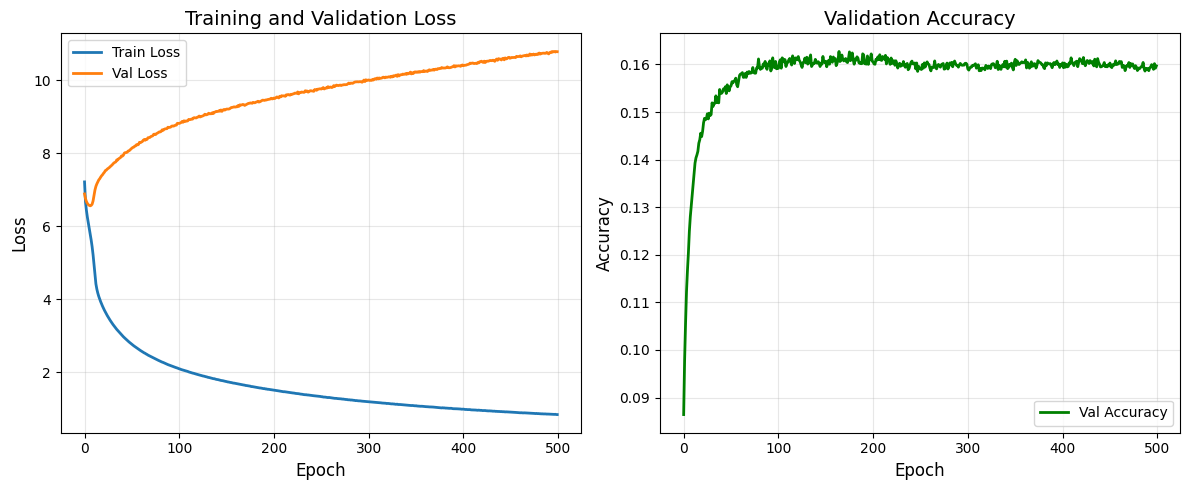


TRAINING SUMMARY
Total Epochs:        500
Final Train Loss:    0.8392
Final Val Loss:      10.7826
Final Val Accuracy:  0.1597 (15.97%)
Best Val Loss:       6.5594 (epoch 7)
Best Val Accuracy:   0.1627 (16.27%) (epoch165)


In [18]:

import json
import os
import matplotlib.pyplot as plt

# Try to use existing variables, otherwise load from saved metrics
try:
    # Check if variables exist from training
    _ = train_losses, val_losses, val_accs
    print("Using metrics from current session")
except NameError:
    # Load from saved file
    print("Loading metrics from training_metrics.json...")
    metrics_path = os.path.join(OUT_DIR, "training_metrics.json")

    if os.path.exists(metrics_path):
        with open(metrics_path, 'r') as f:
            metrics = json.load(f)
            train_losses = metrics['train_losses']
            val_losses = metrics['val_losses']
            val_accs = metrics['val_accs']
            print(f"✅ Loaded {len(train_losses)} epochs of metrics")
    else:
        raise FileNotFoundError(f"Could not find {metrics_path}")

plt.figure(figsize=(12, 5))

# Subplot 1: Loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accs, label='Val Accuracy', color='green', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Validation Accuracy', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Total Epochs:        {len(train_losses)}")
print(f"Final Train Loss:    {train_losses[-1]:.4f}")
print(f"Final Val Loss:      {val_losses[-1]:.4f}")
print(f"Final Val Accuracy:  {val_accs[-1]:.4f} ({val_accs[-1]*100:.2f}%)")
print(f"Best Val Loss:       {min(val_losses):.4f} (epoch {val_losses.index(min(val_losses))+1})")
print(f"Best Val Accuracy:   {max(val_accs):.4f} ({max(val_accs)*100:.2f}%) (epoch{val_accs.index(max(val_accs))+1})")
print("="*60)

In [11]:
import torch
import os

full_checkpoint = os.path.join(OUT_DIR, "final_model.pth")
streamlit_model = os.path.join(OUT_DIR, "model_for_streamlit.pth")

# Load full checkpoint
print("Loading full checkpoint...")
full_ckpt = torch.load(full_checkpoint, map_location='cpu')

# Save ONLY what's needed for inference
torch.save({
    'model_state': full_ckpt['model_state'],  # Model weights only
    'vocab_size': vocab_size,
    'embed_dim': EMBED_DIM,
    'context_len': CONTEXT_LEN,
    'hidden_layers': HIDDEN_LAYERS,
    'hidden_size': HIDDEN_SIZE,
    'activation': ACTIVATION,
    'val_loss': full_ckpt.get('val_loss'),
    'val_acc': full_ckpt.get('val_acc'),
}, streamlit_model)

# Show size reduction
original_size = os.path.getsize(full_checkpoint) / (1024**2)
new_size = os.path.getsize(streamlit_model) / (1024**2)

print(f"\n✅ Created lightweight model for Streamlit!")
print(f"   Original: {original_size:.1f} MB")
print(f"   Streamlit: {new_size:.1f} MB")
print(f"   Saved: {original_size - new_size:.1f} MB ({100*(1-new_size/original_size):.0f}% reduction)")
print(f"\n📁 File: {streamlit_model}")
print(f"\n💡 Use this file in your Streamlit app for deployment!")

Loading full checkpoint...

✅ Created lightweight model for Streamlit!
   Original: 595.4 MB
   Streamlit: 198.5 MB
   Saved: 396.9 MB (67% reduction)

📁 File: /kaggle/working/model_for_streamlit.pth

💡 Use this file in your Streamlit app for deployment!


EMBEDDING VISUALIZATION FOR NATURAL LANGUAGE (Paul Graham Essays)
Loaded embeddings shape: (46328, 64)
Vocabulary size: 46328

Token Categories Found in Vocabulary:
--------------------------------------------------------------------------------
synonyms_good       :   6 tokens
synonyms_bad        :   6 tokens
synonyms_big        :   6 tokens
synonyms_small      :   5 tokens
synonyms_think      :   6 tokens
antonyms            :  22 tokens
pronouns            :  21 tokens
verbs               :  40 tokens
adverbs             :  22 tokens
names               :  14 tokens
time_words          :  18 tokens
numbers             :  16 tokens
questions           :   8 tokens
prepositions        :  18 tokens

Total anchor tokens selected: 152

Computing t-SNE for 500 tokens...
t-SNE completed successfully!

adjustText not available - labels may overlap


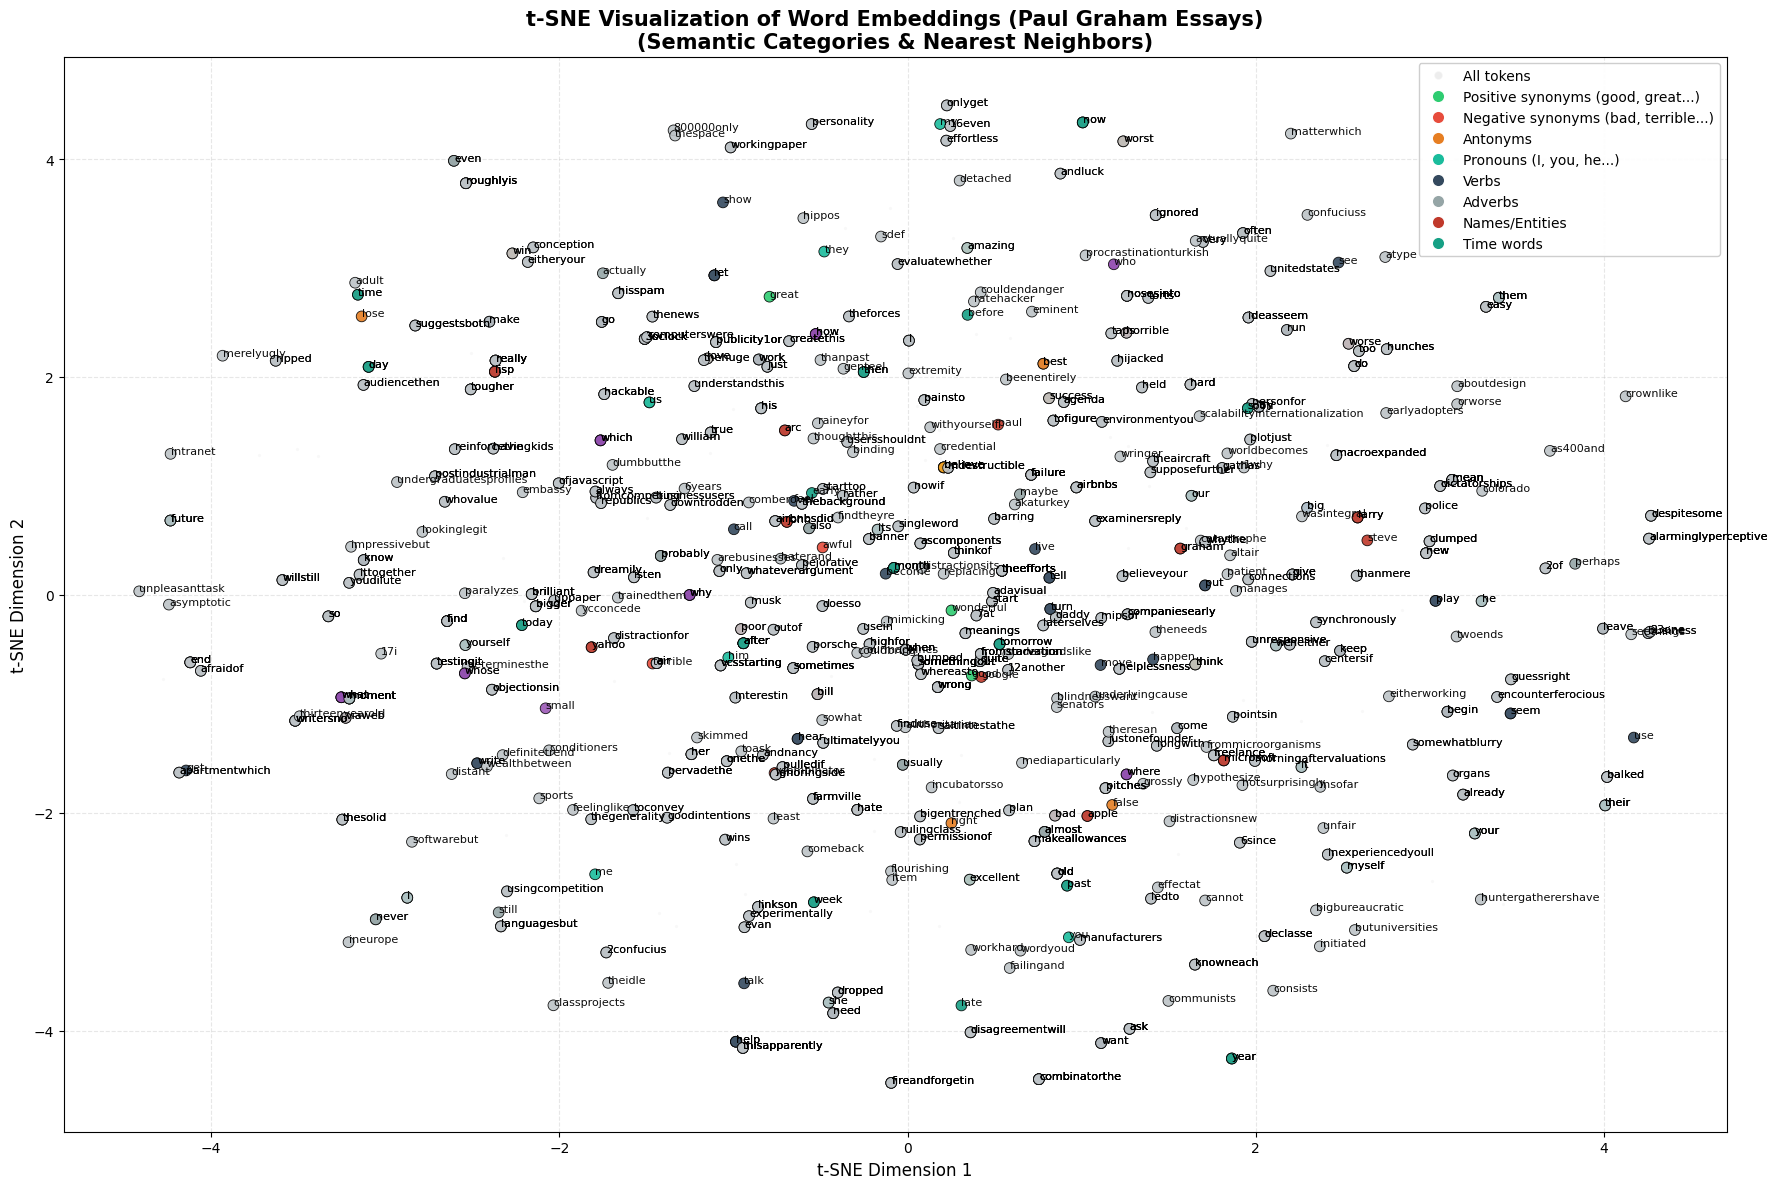

In [22]:
# Embedding Visualization for Natural Language (Paul Graham Essays)
import os, json, numpy as np, matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import torch

# CONFIG — adjust paths if needed
MODEL_PATH = os.path.join(OUT_DIR, "best_model.pth")   # or "model_for_streamlit.pth"
VOCAB_PATH = VOCAB_PATH                                 # should be set earlier
EMBED_DIM = EMBED_DIM                                   # must match trained model
CONTEXT_LEN = CONTEXT_LEN
N_SHOW_ANCHORS = 40             # number of anchor tokens to label
N_NEIGHBORS = 5                 # label each anchor plus these nearest neighbors
TSNE_PERPLEXITY = 40
TSNE_RANDOM_STATE = 42
USE_ADJUSTTEXT = True           # will try to import adjustText; if missing, continue without it

# --- load vocab & model embeddings ---
with open(VOCAB_PATH, 'r', encoding='utf-8') as f:
    vocab = json.load(f)
vocab_size = len(vocab)
word2idx = {w:i for i,w in enumerate(vocab)}

# reload model (MLPNextWord class must be defined in the notebook as earlier)
ckpt = torch.load(MODEL_PATH, map_location='cpu')
model = MLPNextWord(vocab_size, EMBED_DIM, CONTEXT_LEN, HIDDEN_LAYERS, HIDDEN_SIZE, ACTIVATION)
model.load_state_dict(ckpt['model_state'])
model.eval()
embeddings = model.embed.weight.detach().cpu().numpy()   # shape: (V, E)
print("="*80)
print("EMBEDDING VISUALIZATION FOR NATURAL LANGUAGE (Paul Graham Essays)")
print("="*80)
print(f"Loaded embeddings shape: {embeddings.shape}")
print(f"Vocabulary size: {vocab_size}")
print()

# --- Define semantic categories for natural language ---
# synonyms, antonyms, names, pronouns, verbs, adverbs, unrelated words

# 1. Synonyms (words with similar meaning)
synonyms_good = ["good", "great", "excellent", "wonderful", "amazing", "fantastic", "brilliant", "superb"]
synonyms_bad = ["bad", "terrible", "awful", "horrible", "poor", "worse"]
synonyms_big = ["big", "large", "huge", "enormous", "giant", "massive"]
synonyms_small = ["small", "tiny", "little", "minor", "minimal"]
synonyms_think = ["think", "believe", "suppose", "consider", "imagine", "assume"]

# 2. Antonyms (opposite meanings)
antonym_pairs = [
    ("good", "bad"), ("big", "small"), ("start", "end"), ("easy", "hard"),
    ("right", "wrong"), ("true", "false"), ("old", "new"), ("best", "worst"),
    ("love", "hate"), ("success", "failure"), ("win", "lose")
]
antonyms_all = [w for pair in antonym_pairs for w in pair]

# 3. Personal pronouns (related grammatically)
pronouns = ["i", "you", "he", "she", "it", "we", "they", "me", "him", "her", "us", "them",
            "my", "your", "his", "her", "its", "our", "their", "myself", "yourself"]

# 4. Common verbs (action words)
verbs = ["do", "make", "get", "go", "know", "think", "see", "come", "want", "use",
         "find", "give", "tell", "work", "call", "try", "ask", "need", "feel", "become",
         "leave", "put", "mean", "keep", "let", "begin", "seem", "help", "talk", "turn",
         "start", "show", "hear", "play", "run", "move", "live", "believe", "happen", "write"]

# 5. Adverbs (modify verbs)
adverbs = ["very", "really", "actually", "just", "even", "still", "also", "never",
           "always", "often", "usually", "sometimes", "maybe", "perhaps", "probably",
           "quite", "rather", "almost", "already", "only", "too", "so"]

# 6. Common names (Paul Graham essays often mention people)
names = ["paul", "graham", "john", "bill", "steve", "larry", "yahoo", "google",
         "microsoft", "apple", "lisp", "arc", "viaweb", "ycombinator"]

# 7. Time-related words (semantic group)
time_words = ["now", "then", "when", "before", "after", "today", "tomorrow", "yesterday",
              "year", "time", "day", "week", "month", "moment", "early", "late", "soon", "future", "past"]

# 8. Numbers and quantifiers (unrelated semantically to most other words)
numbers_quant = ["one", "two", "three", "first", "second", "many", "few", "some", "all",
                 "most", "every", "each", "both", "several", "no", "any"]

# 9. Question words (grammatical category)
question_words = ["what", "who", "where", "when", "why", "how", "which", "whose"]

# 10. Common prepositions (function words - weak semantic signal)
prepositions = ["in", "on", "at", "to", "for", "with", "from", "about", "by", "as",
                "into", "through", "over", "between", "after", "before", "under", "around"]

# Helper function to get indices for tokens that exist in vocab
def get_idx_list(token_list):
    return [vocab.index(t) for t in token_list if t in vocab]

# Build category mappings
categories = {
    'synonyms_good': get_idx_list(synonyms_good),
    'synonyms_bad': get_idx_list(synonyms_bad),
    'synonyms_big': get_idx_list(synonyms_big),
    'synonyms_small': get_idx_list(synonyms_small),
    'synonyms_think': get_idx_list(synonyms_think),
    'antonyms': get_idx_list(antonyms_all),
    'pronouns': get_idx_list(pronouns),
    'verbs': get_idx_list(verbs),
    'adverbs': get_idx_list(adverbs),
    'names': get_idx_list(names),
    'time_words': get_idx_list(time_words),
    'numbers': get_idx_list(numbers_quant),
    'questions': get_idx_list(question_words),
    'prepositions': get_idx_list(prepositions),
}

# Print category statistics
print("Token Categories Found in Vocabulary:")
print("-" * 80)
for cat_name, indices in categories.items():
    print(f"{cat_name:20s}: {len(indices):3d} tokens")
print()

# Build anchor list from selected categories (skip prepositions as they're weak semantic)
anchor_idx = []
priority_categories = ['synonyms_good', 'synonyms_bad', 'antonyms', 'pronouns', 'verbs', 
                       'adverbs', 'names', 'time_words', 'questions']
for cat_name in priority_categories:
    anchor_idx.extend(categories[cat_name])
anchor_idx = list(dict.fromkeys(anchor_idx))  # remove duplicates, preserve order

# Add some high-frequency tokens if needed
if len(anchor_idx) < N_SHOW_ANCHORS:
    norms = np.linalg.norm(embeddings, axis=1)
    cand = np.argsort(-norms)[:N_SHOW_ANCHORS*2].tolist()
    for c in cand:
        if c not in anchor_idx and len(anchor_idx) < N_SHOW_ANCHORS:
            anchor_idx.append(int(c))

print(f"Total anchor tokens selected: {len(anchor_idx)}")
print()

# --- t-SNE dimensionality reduction ---
# For visualization clarity, use subset if vocabulary is very large
MAX_TOKENS = 500
use_subset = embeddings.shape[0] > MAX_TOKENS

if use_subset:
    # Include all anchors + random sample
    subset_idx = list(set(anchor_idx) | set(np.random.choice(
        [i for i in range(embeddings.shape[0]) if i not in anchor_idx],
        min(MAX_TOKENS - len(anchor_idx), embeddings.shape[0] - len(anchor_idx)),
        replace=False
    )))
    subset_idx = sorted(subset_idx)
    X = embeddings[subset_idx]
    vocab_sub = [vocab[i] for i in subset_idx]
    remap = {old_i: new_i for new_i, old_i in enumerate(subset_idx)}
    anchor_idx = [remap[i] for i in anchor_idx if i in remap]
else:
    X = embeddings
    vocab_sub = vocab
    subset_idx = np.arange(len(vocab_sub))

print(f"Computing t-SNE for {X.shape[0]} tokens...")

try:
    tsne = TSNE(n_components=2, perplexity=min(TSNE_PERPLEXITY, (X.shape[0]-1)//3), 
                random_state=TSNE_RANDOM_STATE, init='pca', learning_rate='auto', n_jobs=-1)
    X_2d = tsne.fit_transform(X)
    print("t-SNE completed successfully!")
except Exception as e:
    print(f"t-SNE failed: {e}")
    print("Falling back to PCA...")
    pca = PCA(n_components=2, random_state=TSNE_RANDOM_STATE)
    X_2d = pca.fit_transform(X)
print()

# --- Compute cosine similarity for finding semantic neighbors ---
cos_sim = cosine_similarity(X)

# --- Prepare visualization ---
plt.figure(figsize=(18,12))
ax = plt.gca()

# Plot all tokens as background (light gray)
ax.scatter(X_2d[:,0], X_2d[:,1], s=5, alpha=0.15, c='lightgray', linewidths=0)

# Prepare data for labeled tokens (anchors + neighbors)
labels = []
points_x = []
points_y = []
colors = []

# Color palette for categories
color_map = {
    'synonyms_good': '#2ecc71',    # green (positive)
    'synonyms_bad': '#e74c3c',     # red (negative)
    'synonyms_big': '#3498db',     # blue
    'synonyms_small': '#9b59b6',   # purple
    'synonyms_think': '#f39c12',   # orange
    'antonyms': '#e67e22',         # dark orange
    'pronouns': '#1abc9c',         # turquoise
    'verbs': '#34495e',            # dark gray
    'adverbs': '#95a5a6',          # gray
    'names': '#c0392b',            # dark red
    'time_words': '#16a085',       # dark turquoise
    'questions': '#8e44ad',        # dark purple
    'neighbor': '#bdc3c7'          # light gray for neighbors
}

# Function to get category of token index
def get_category(idx):
    original_idx = subset_idx[idx] if use_subset else idx
    for cat_name, cat_indices in categories.items():
        if original_idx in cat_indices and cat_name in color_map:
            return cat_name
    return None

# For each anchor, find nearest neighbors and label them
for anchor in anchor_idx:
    # Find nearest neighbors
    sims = cos_sim[anchor]
    nn_indices = np.argsort(-sims)[1:N_NEIGHBORS+1]  # exclude self
    
    # Add anchor token
    labels.append(vocab_sub[anchor])
    points_x.append(X_2d[anchor, 0])
    points_y.append(X_2d[anchor, 1])
    cat = get_category(anchor)
    colors.append(color_map.get(cat, '#7f7f7f'))
    
    # Add neighbor tokens
    for nn_idx in nn_indices:
        labels.append(vocab_sub[nn_idx])
        points_x.append(X_2d[nn_idx, 0])
        points_y.append(X_2d[nn_idx, 1])
        colors.append(color_map['neighbor'])

# Plot labeled points with larger size
ax.scatter(points_x, points_y, s=60, c=colors, edgecolor='black', linewidth=0.6, alpha=0.9, zorder=5)

# Add text labels
texts = []
for x, y, label in zip(points_x, points_y, labels):
    t = ax.text(x, y, label, fontsize=8, weight='normal', alpha=0.95, zorder=10)
    texts.append(t)

# Try to improve label layout with adjustText
if USE_ADJUSTTEXT:
    try:
        from adjustText import adjust_text
        adjust_text(texts, only_move={'points':'xy', 'texts':'xy'}, 
                   arrowprops=dict(arrowstyle='-', color='gray', lw=0.5, alpha=0.6),
                   force_text=(0.3, 0.5), force_points=(0.2, 0.5),
                   expand_points=(1.3, 1.3), expand_text=(1.3, 1.3))
    except ImportError:
        print("adjustText not available - labels may overlap")
    except Exception as e:
        print(f"adjustText failed: {e}")

# Create legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='All tokens', 
           markerfacecolor='lightgray', markersize=6, alpha=0.4),
    Line2D([0], [0], marker='o', color='w', label='Positive synonyms (good, great...)', 
           markerfacecolor=color_map['synonyms_good'], markersize=9),
    Line2D([0], [0], marker='o', color='w', label='Negative synonyms (bad, terrible...)', 
           markerfacecolor=color_map['synonyms_bad'], markersize=9),
    Line2D([0], [0], marker='o', color='w', label='Antonyms', 
           markerfacecolor=color_map['antonyms'], markersize=9),
    Line2D([0], [0], marker='o', color='w', label='Pronouns (I, you, he...)', 
           markerfacecolor=color_map['pronouns'], markersize=9),
    Line2D([0], [0], marker='o', color='w', label='Verbs', 
           markerfacecolor=color_map['verbs'], markersize=9),
    Line2D([0], [0], marker='o', color='w', label='Adverbs', 
           markerfacecolor=color_map['adverbs'], markersize=9),
    Line2D([0], [0], marker='o', color='w', label='Names/Entities', 
           markerfacecolor=color_map['names'], markersize=9),
    Line2D([0], [0], marker='o', color='w', label='Time words', 
           markerfacecolor=color_map['time_words'], markersize=9),
]
ax.legend(handles=legend_elements, loc='upper right', framealpha=0.95, fontsize=10)

ax.set_title("t-SNE Visualization of Word Embeddings (Paul Graham Essays)\n(Semantic Categories & Nearest Neighbors)", 
             fontsize=15, weight='bold')
ax.set_xlabel("t-SNE Dimension 1", fontsize=12)
ax.set_ylabel("t-SNE Dimension 2", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()